Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Load Required librariese and  Import Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Rescaling  # Corrected Import
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrected Import
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

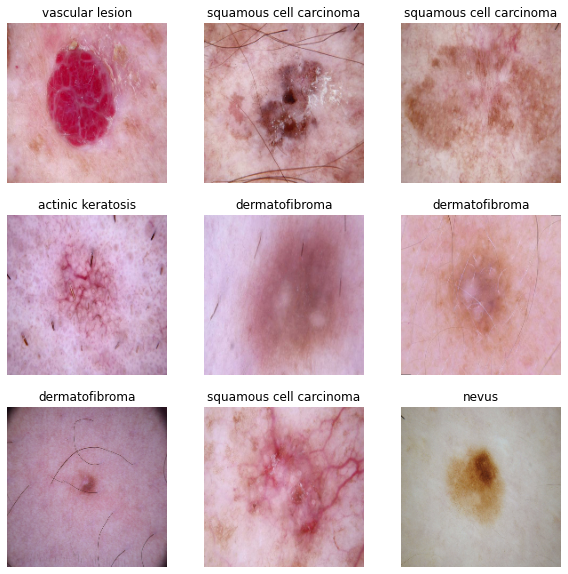

In [8]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training. 
- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
# Number of target labels
target_labels = 9

# Image dimensions
img_height = 180  # Set your image height
img_width = 180   # Set your image width

# Define model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # ✅ FIXED IMPORT
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)
])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [11]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 89s 247ms/step - accuracy: 0.2358 - loss: 1.9640 - val_accuracy: 0.5069 - val_loss: 1.3226
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 67s 238ms/step - accuracy: 0.5093 - loss: 1.3023 - val_accuracy: 0.5928 - val_loss: 1.1077
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 67s 238ms/step - accuracy: 0.6440 - loss: 0.9707 - val_accuracy: 0.7098 - val_loss: 0.8071
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 58s 206ms/step - accuracy: 0.7473 - loss: 0.6923 - val_accuracy: 0.7543 - val_loss: 0.6892
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 57s 203ms/step - accuracy: 0.8256 - loss: 0.4918 - val_accuracy: 0.7686 - val_loss: 0.6367
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 57s 204ms/step - accuracy: 0.8688 - loss: 0.3732 - val_accuracy: 0.8153 - val_loss: 0.5134
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 64s 227ms/step - accuracy: 0.8927 - loss: 0.2975 - val_accuracy: 0.8620 - val_loss: 0.4571
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 60s 212ms/step - accuracy: 0.9185 - loss: 0

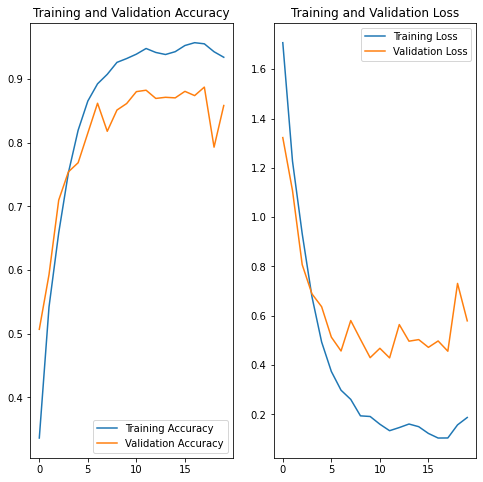

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

***Inferences:***

- The training accuracy of the model shows a steady increase of upto 88%, while validation accuracy remains consistently ~ 54%.

- A high training accuracy indicates the model has effectively captured the noise within the data. However,  the poor performance on validation data indicates a lack of generalizability.

- These inferences indicate the presence of overfitting. To mitigate this issue, augmentation techniques will be applied. Since the training data is limited, additional samples will be created by introducing slight modifications to the existing data (such as flipping images horizontally or vertically, applying small rotations, etc.), which will then be utilized for training the model.

In [15]:
# Image dimensions
img_height = 180  # Update with actual height
img_width = 180   # Update with actual width

# Data Augmentation Pipeline
augmentation_data = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),  # 
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Print summary to check augmentation layers
augmentation_data.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 180, 180, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

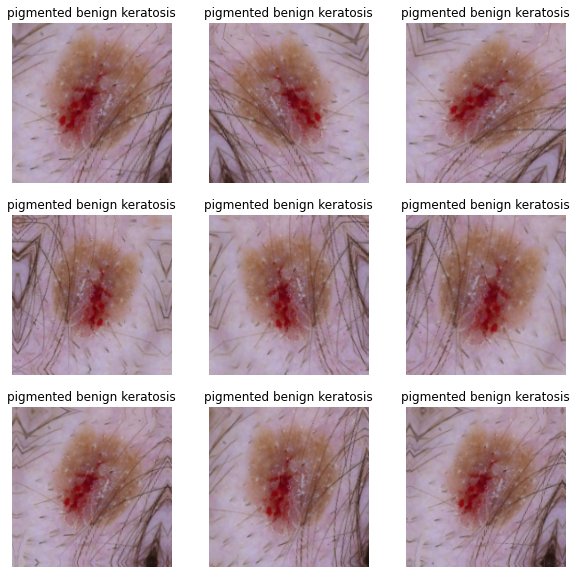

In [16]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model, compile and train the model

In [17]:
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

# Define Model
model = keras.Sequential([
    augmentation_data,  
    layers.Rescaling(1./255),  # 
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)
])

# Print Model Summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [18]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [19]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 86s 291ms/step - accuracy: 0.1961 - loss: 2.1274 - val_accuracy: 0.4312 - val_loss: 1.4509
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 286ms/step - accuracy: 0.4309 - loss: 1.4782 - val_accuracy: 0.4784 - val_loss: 1.3098
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 287ms/step - accuracy: 0.4806 - loss: 1.3322 - val_accuracy: 0.5340 - val_loss: 1.2293
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 287ms/step - accuracy: 0.5172 - loss: 1.2551 - val_accuracy: 0.5229 - val_loss: 1.2608
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 283ms/step - accuracy: 0.5423 - loss: 1.1788 - val_accuracy: 0.5581 - val_loss: 1.1238
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 300ms/step - accuracy: 0.5805 - loss: 1.0997 - val_accuracy: 0.5648 - val_loss: 1.1179
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 110s 390ms/step - accuracy: 0.5893 - loss: 1.0643 - val_accuracy: 0.5839 - val_loss: 1.0765
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 117s 415ms/step - accuracy: 0.5991 - loss:

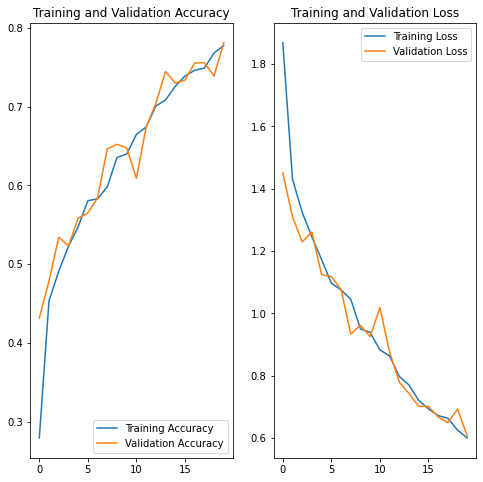

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Inferences:***

- Using augmented data has successfully mitigated overfitting.

- The training and validation accuracy of the model are now comparable.

- However, both the training and validation datasets exhibit poor performance, suggesting that the model is now underfitting.

#### Find the distribution of classes in the training dataset.
#### 
**Context:** Real-life datasets often exhibit class imbalance, where one class has a significantly higher number of samples compared to others. This imbalance can adversely impact the quality of the final model. Therefore, as a critical sanity check, it is essential to examine the class distribution within the dataset to identify and address any imbalances effectively.

In [21]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [22]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [23]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
1,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
2,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
3,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
4,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis


In [24]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

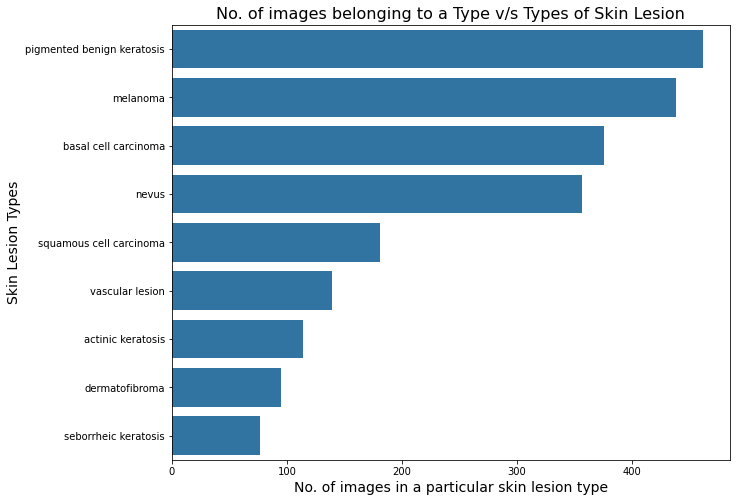

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

# Sort the dataframe by count of each label
sorted_df = lesions_df['Label'].value_counts().reset_index()
sorted_df.columns = ['Label', 'Count']

# Plot the countplot using sorted labels
sns.countplot(
    y="Label", 
    data=lesions_df, 
    order=sorted_df['Label']  # Specify the order based on sorted counts
)

# Add titles and labels
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()


In [26]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

***Inferences:***

- The training data clearly exhibits a class imbalance.  
-2. The class **"seborrheic keratosis"** has the fewest samples, making up roughly **3.44%** of the dataset.  -
3. **"Pigmented benign keratosis"** and **"melanoma"** dominate the dataset, accounting for approximately **20.63%** and **19.56%** of the samples, respectively.

Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.¶

In [27]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2057FB6A790>: 100%|█| 500/500 [00:11<00:


Initialised with 376 image(s) found.
Output directory set to C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20578F5F880>: 100%|█| 500/500 [00:10<00:


Initialised with 95 image(s) found.
Output directory set to C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2101x1943 at 0x2057FB692E0>: 100%|█| 500/500 [00:50<0


Initialised with 462 image(s) found.
Output directory set to C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20578F9AD00>: 100%|█| 500/500 [00:09<00:00, 52.95 Samples/


Initialised with 77 image(s) found.
Output directory set to C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2057FAE1490>: 100%|█| 500/500 [00:23<00


Initialised with 181 image(s) found.
Output directory set to C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2057FAD3280>: 100%|█| 500/500 [00:10<00:00, 48.22 Samples/


Initialised with 139 image(s) found.
Output directory set to C:\Users\shasingh\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2057FB6F100>: 100%|█| 500/500 [00:09<00:


In [28]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


In [29]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0b08f377-c8d6-428c-942a-9da79648f7a7.jpg',
 'C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_56f458e1-0958-4b68-b83d-a4e0a51b3817.jpg',
 'C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6a32fd62-ebc4-4e16-8de8-70f31ab9e1ff.jpg',
 'C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7717cf04-2d9f-4c53-baee-a8b1ed37d313.jpg',
 'C:\\Users\\shasingh\\Downloads\\CNN_assignment\\Skin cancer IS

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(15739, 2)

In [33]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
1,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
2,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
3,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis
4,C:\Users\shasingh\Downloads\CNN_assignment\Ski...,actinic keratosis


In [34]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: count, dtype: int64

In [35]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    12.47
melanoma                      12.31
basal cell carcinoma          11.92
nevus                         11.80
squamous cell carcinoma       10.68
vascular lesion               10.41
actinic keratosis             10.25
dermatofibroma                10.13
seborrheic keratosis          10.02
Name: proportion, dtype: float64

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [37]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### Create your model (make sure to include normalization)

In [39]:
from tensorflow.keras.layers import Rescaling

model = Sequential([
  augmentation_data,
  Rescaling(1./255),  # 
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


In [40]:
#### Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
#### Train your model

In [43]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 343s 842ms/step - accuracy: 0.2943 - loss: 3.1541 - val_accuracy: 0.1999 - val_loss: 9.7212
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 324s 822ms/step - accuracy: 0.4072 - loss: 1.5018 - val_accuracy: 0.4268 - val_loss: 1.5036
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 327s 830ms/step - accuracy: 0.4557 - loss: 1.3784 - val_accuracy: 0.3200 - val_loss: 1.7791
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 334s 847ms/step - accuracy: 0.4963 - loss: 1.2836 - val_accuracy: 0.4881 - val_loss: 1.2894
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 334s 848ms/step - accuracy: 0.5056 - loss: 1.2428 - val_accuracy: 0.4245 - val_loss: 1.7882
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 338s 857ms/step - accuracy: 0.5350 - loss: 1.1841 - val_accuracy: 0.5383 - val_loss: 1.1422
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 377s 845ms/step - accuracy: 0.5485 - loss: 1.1378 - val_accuracy: 0.5828 - val_loss: 1.1003
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 394s 875ms/step - accuracy: 0.5689 -

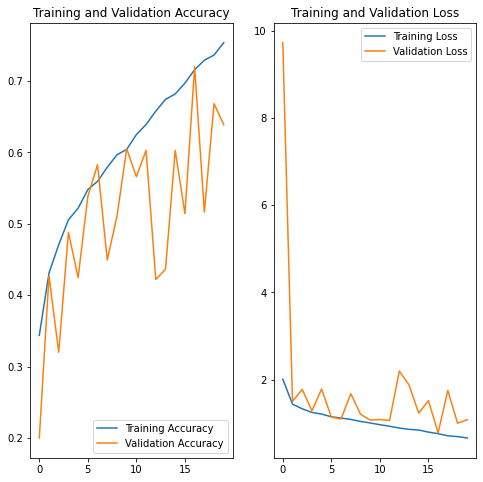

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Inferences:***

- Adding batch normalization to the model resulted in a modest improvement in both training and validation accuracy.
- Developing an alternative model without batch normalization is intended to explore potential accuracy enhancements.

#### Creating another model (without batch normalization)

In [49]:
# Create the model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),  # ✅ Corrected: Remove `experimental.preprocessing`
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [51]:
%%time
# train the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.1946 - loss: 2.0624
Epoch 1: val_accuracy improved from -inf to 0.45758, saving model to model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 164s 401ms/step - accuracy: 0.1949 - loss: 2.0617 - val_accuracy: 0.4576 - val_loss: 1.4344
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.4662 - loss: 1.3907
Epoch 2: val_accuracy improved from 0.45758 to 0.53194, saving model to model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 157s 399ms/step - accuracy: 0.4662 - loss: 1.3906 - val_accuracy: 0.5319 - val_loss: 1.2527
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5186 - loss: 1.2723
Epoch 3: val_accuracy improved from 0.53194 to 0.58310, saving model to model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 159s 404ms/step - accuracy: 0.5187 - loss: 1.2722 - val_accuracy: 0.5831 - val_loss: 1.1445
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.5583 - loss: 1.1761
Epoch 4: val_accuracy did not improv

In [52]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

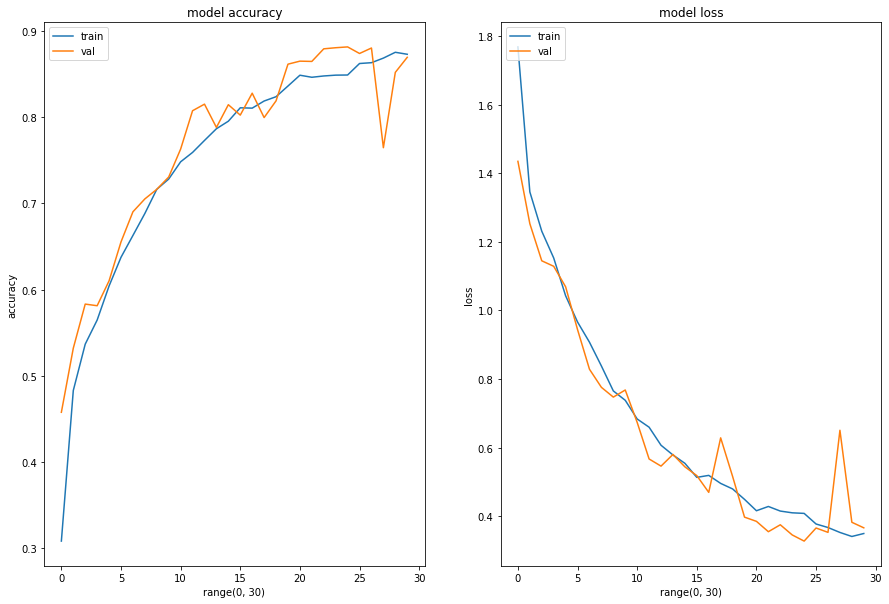

In [53]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


***Inferences:***
- The final model demonstrates a well-balanced performance, with no indications of underfitting or overfitting.  

- Incorporating class rebalancing has significantly improved the model's performance on both the training and validation datasets.  

- After setting to 30 epochs, the final model achieves an accuracy of 91% on the training set and approximately 83% on the validation set.  

- The minimal gap between training and validation accuracies highlights the strong generalization ability of the final CNN model.  

- Introducing batch normalization did not result in any improvement in training or validation accuracy.  

In [54]:
### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Actual Class: melanoma
Predicted Class: nevus


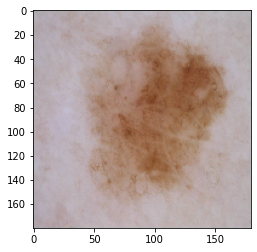

In [55]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[3], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[3] +'\n'+ "Predicted Class: " + predicted_class)